Hola **Sebastian**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

# Descripcipción del proyecto | sin usar BERT | La lematizacion con SpaCy tarda unos 8 min.

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import spacy
import re


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

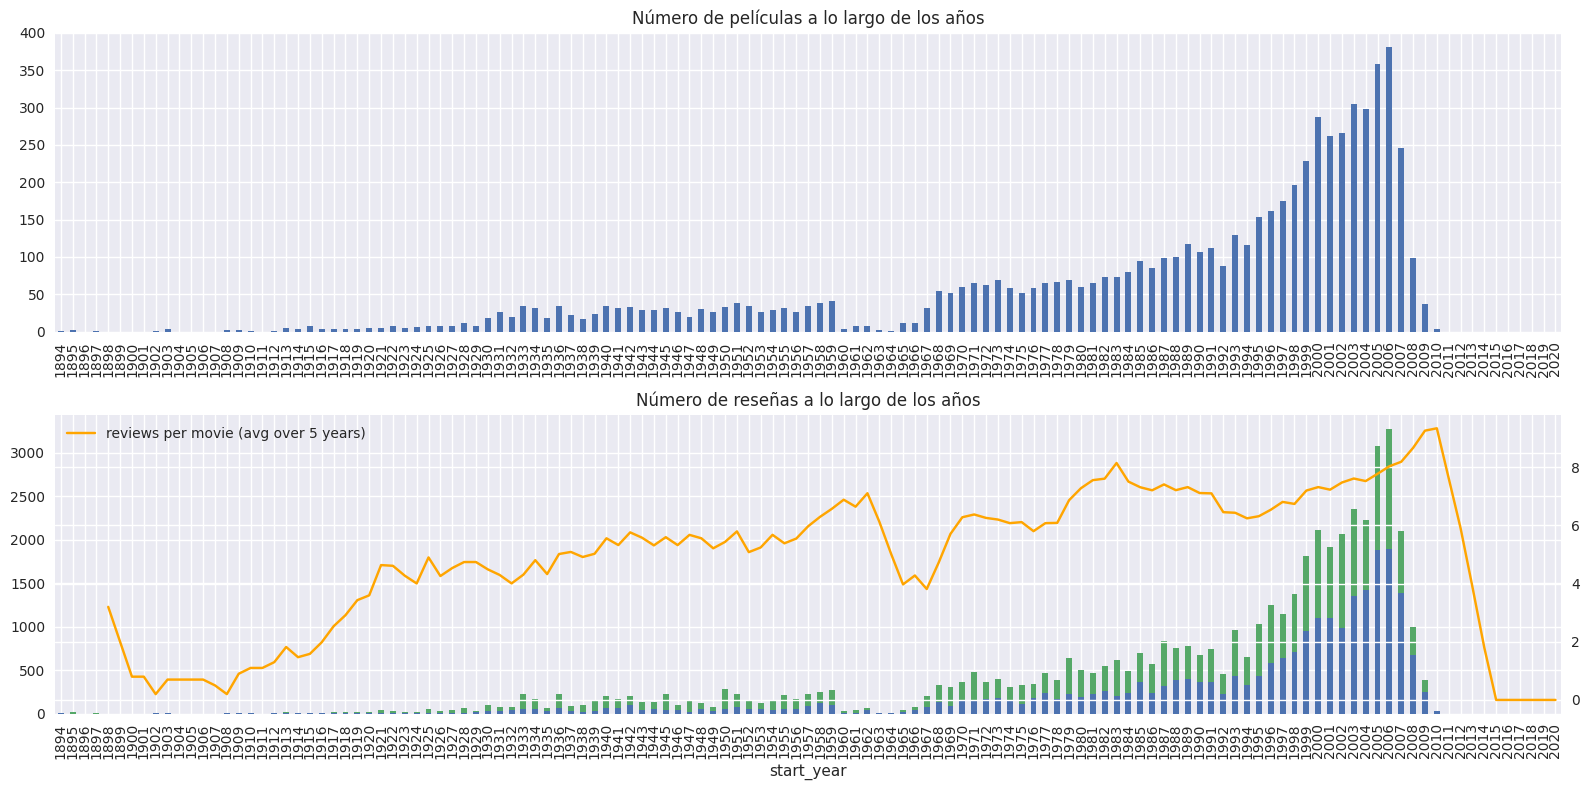

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

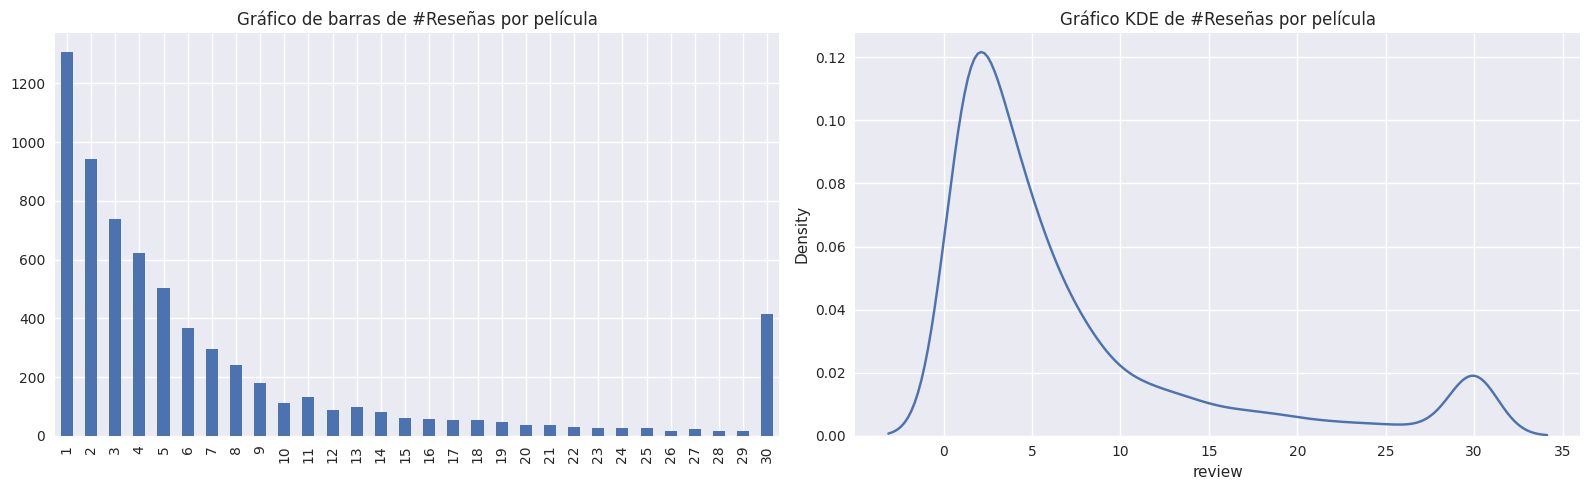

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

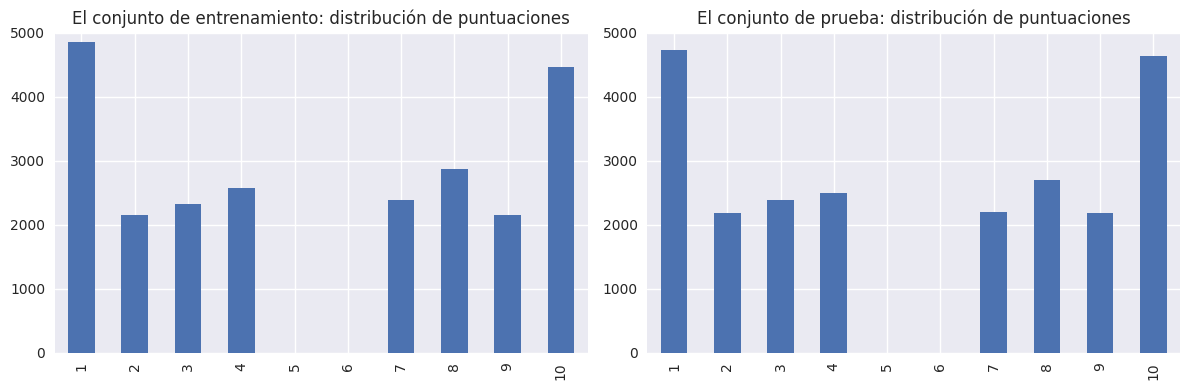

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


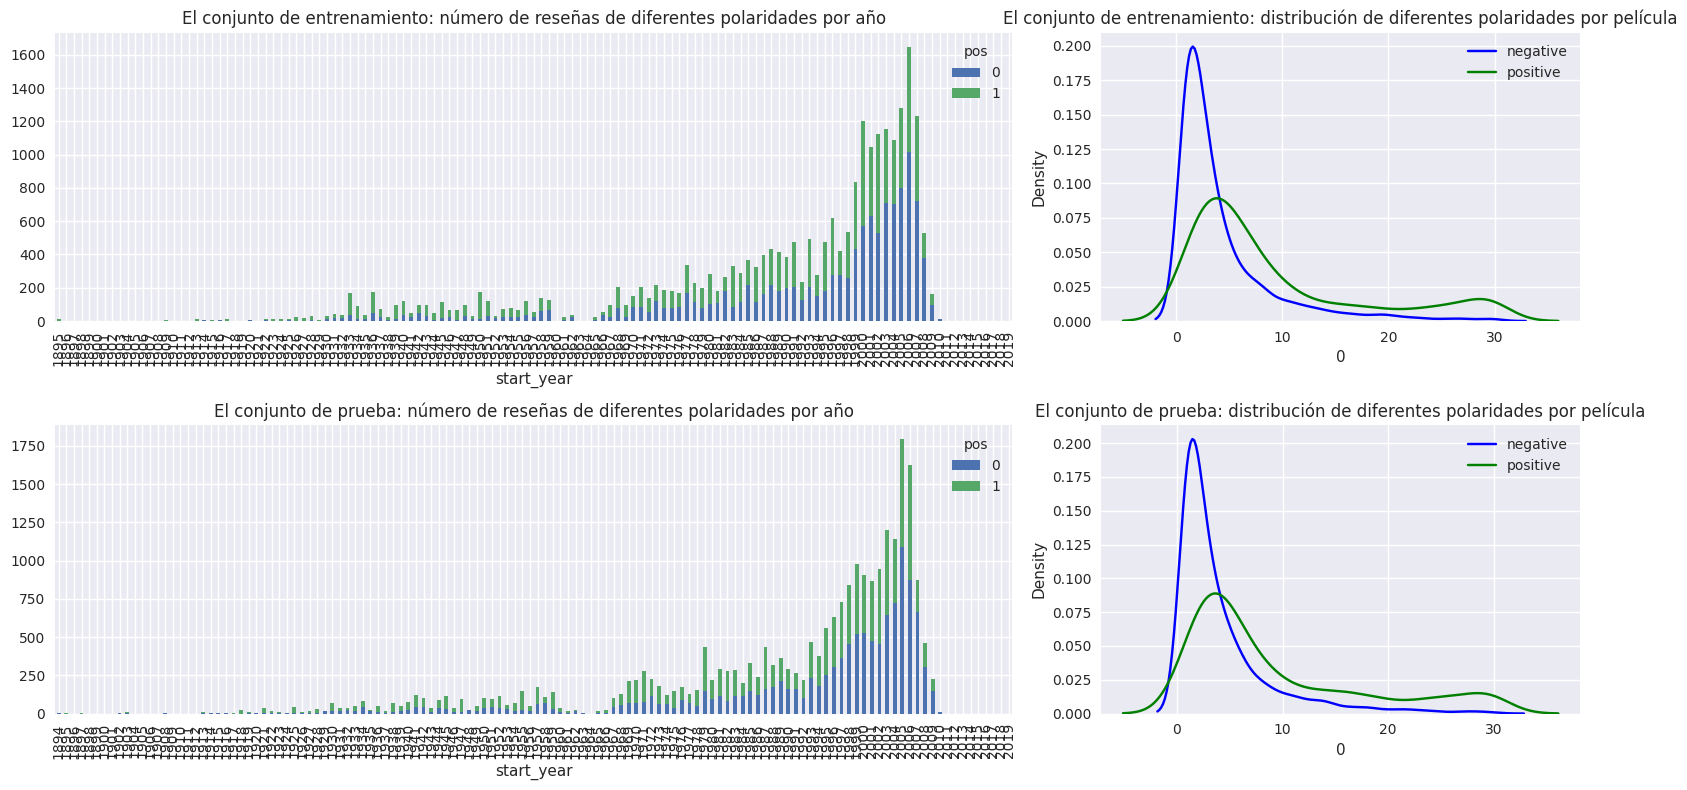

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, el EDA es un proceso necesario en cada proyecto para entender los datos con los que se trabajará por lo que siempre procura complementar con una redacción de las conclusiones de las gráficas mostradas
</div>

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

Limpieza

In [12]:
%%time

def clear_text(text):


    clean_text = re.sub(r"[^a-zA-z\']", " ", text)
    clean_text = " ".join(clean_text.split())


    return clean_text

df_reviews["review_clean"] = df_reviews["review"].apply(clear_text)


CPU times: user 3.01 s, sys: 51.9 ms, total: 3.07 s
Wall time: 3.07 s


In [13]:
print("Reseña limpia:")
print()
print(df_reviews.loc[100, "review_clean"])

Reseña limpia:

Years ago Sara a young girl witnessed her parents being murdered now as an adult she suffers from various mental ailments did I mention she has an imaginary friend This film lulls the viewer not into a sense of tension mind you but rather a sense of sleepiness Deathly boring I found it hard to sit through as I could feel my eyelids growing heavier and heavier with each endless minute of mindless prattle and supposed 'mystery' Is Sara going crazy or is it the paranormal A better question would be Who cares And the answer to that no one No one at all Skip this film save yourself some time better suited to do other more worthwhile tasks My Grade D


Lematizacion spaCy

In [14]:
%%time

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def spacy(text):

    doc = nlp(text.lower())

    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return " ".join(lemmas)

df_reviews["review_spacy"] = df_reviews["review_clean"].apply(spacy)

CPU times: user 9min, sys: 4.18 s, total: 9min 5s
Wall time: 9min 5s


In [15]:
print("Reseña lematizada con la libreria spaCy:")
print()
print(df_reviews.loc[100, "review_spacy"])

Reseña lematizada con la libreria spaCy:

year ago sara a young girl witness her parent be murder now as an adult she suffer from various mental ailment do I mention she have an imaginary friend this film lull the viewer not into a sense of tension mind you but rather a sense of sleepiness deathly boring I find it hard to sit through as I could feel my eyelid grow heavy and heavy with each endless minute of mindless prattle and suppose ' mystery ' be sara go crazy or be it the paranormal a well question would be who care and the answer to that no one no one at all skip this film save yourself some time well suit to do other more worthwhile task my grade d


Lematizacion LNTK

In [16]:
%%time

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

def lntk(text):

    doc = word_tokenize(text.lower())

    lemmas = []
    for token in doc:
        lemmas.append(lemmatizer.lemmatize(token))
    return " ".join(lemmas)

df_reviews["review_lntk"] = df_reviews["review_clean"].apply(lntk)

CPU times: user 58.5 s, sys: 96 ms, total: 58.6 s
Wall time: 58.6 s


In [17]:
print("Reseña lematizada con la libreria LNTK:")
print()
print(df_reviews.loc[100, "review_lntk"])

Reseña lematizada con la libreria LNTK:

year ago sara a young girl witnessed her parent being murdered now a an adult she suffers from various mental ailment did i mention she ha an imaginary friend this film lull the viewer not into a sense of tension mind you but rather a sense of sleepiness deathly boring i found it hard to sit through a i could feel my eyelid growing heavier and heavier with each endless minute of mindless prattle and supposed 'mystery ' is sara going crazy or is it the paranormal a better question would be who care and the answer to that no one no one at all skip this film save yourself some time better suited to do other more worthwhile task my grade d


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto! Realizaste un buen trabajo con la normalización y creando la función de evaluación. La normalización es un paso importante para evitar "ruido" en tus datos y estandarizar el hecho que las palabras estén en casos escritas con mayúsculas y en otros con minúsculas
</div>

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 20)
(23535, 20)


In [19]:
df_reviews_train

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_clean,review_spacy,review_lntk
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,The pakage implies that Warren Beatty and Gold...,the pakage imply that warren beatty and goldie...,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,How the hell did they get this made Presenting...,how the hell do they get this make present its...,how the hell did they get this made presenting...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,This true story of Carlson's Raiders is more o...,this true story of carlson 's raider be more o...,this true story of carlson 's raider is more o...
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,Should have been titled 'Balderdash ' Little i...,should have be title ' balderdash ' little in ...,should have been titled 'balderdash ' little i...
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,The movie 'Gung Ho ' The Story of Carlson's Ma...,the movie ' gung ho ' the story of carlson 's ...,the movie 'gung ho ' the story of carlson 's m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47253,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,O my gosh... Just give me a minute to breath. ...,10,pos,1,train,407,O my gosh Just give me a minute to breath This...,o my gosh just give I a minute to breath this ...,o my gosh just give me a minute to breath this...
47254,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,I can't tell you all how much I love this movi...,10,pos,1,train,408,I can't tell you all how much I love this movi...,I can not tell you all how much I love this mo...,i ca n't tell you all how much i love this mov...
47255,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,Legend of Zu is possibly the most exciting mov...,10,pos,1,train,409,Legend of Zu is possibly the most exciting mov...,legend of zu be possibly the most exciting mov...,legend of zu is possibly the most exciting mov...
47256,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,This movie is well done on so many levels that...,10,pos,1,train,411,This movie is well done on so many levels that...,this movie be well do on so many level that I ...,this movie is well done on so many level that ...


## Trabajar con modelos

### Modelo 0 - Constante

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [21]:
dummy =  pd.Series(1, index=test_target.index)

In [22]:
dummy

2        1
3        1
4        1
5        1
6        1
        ..
47326    1
47327    1
47328    1
47329    1
47330    1
Length: 23535, dtype: int64

In [23]:
print("Exactitud del modelo Dummy: ",accuracy_score(test_target, dummy))
print()
print("Precision o F1 del modelo Dummy: ",f1_score(test_target, dummy))

Exactitud del modelo Dummy:  0.4984916082430423

Precision o F1 del modelo Dummy:  0.6653245243428701


Naturalmente el modelo Dummy solo alcanza una exactitud que ronda el 50%. Que es lo mismo que determinar de manera aleatoria si el comentario es positivo o negativo. Sin embargo, no logro detectar 

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [25]:
train_corpus = df_reviews_train["review_lntk"] # extraer reseñas lematizadas para el entrenamiento
stop_words = set(stopwords.words("english")) # definir las palabras vacías

count_tf_idf_1 = TfidfVectorizer(stop_words=stop_words) # inicializar TfidVercorizer
tf_idf_1 = count_tf_idf_1.fit_transform(train_corpus) # ajustar y transformar el corpus de entrenamiento

features_train = tf_idf_1 # extraer características para el entrenamiento

target_train = train_target # extraer la columna objetivo

test_corpus = df_reviews_test["review_lntk"] # extraer reseñas lematizadas para la prueba

features_test = count_tf_idf_1.transform(test_corpus) # transformar el corpus de entrenamiento

model_1 = LogisticRegression() # inicializar el modelo de regresión logística y ajustarlo
model_1.fit(features_train, target_train)
pred_test = model_1.predict(features_test) # obtener predicciones para la parte de prueba de los datos

# transformar las predicciones en un DataFrame y guardarlo
submission = pd.DataFrame({"pos":pred_test})

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


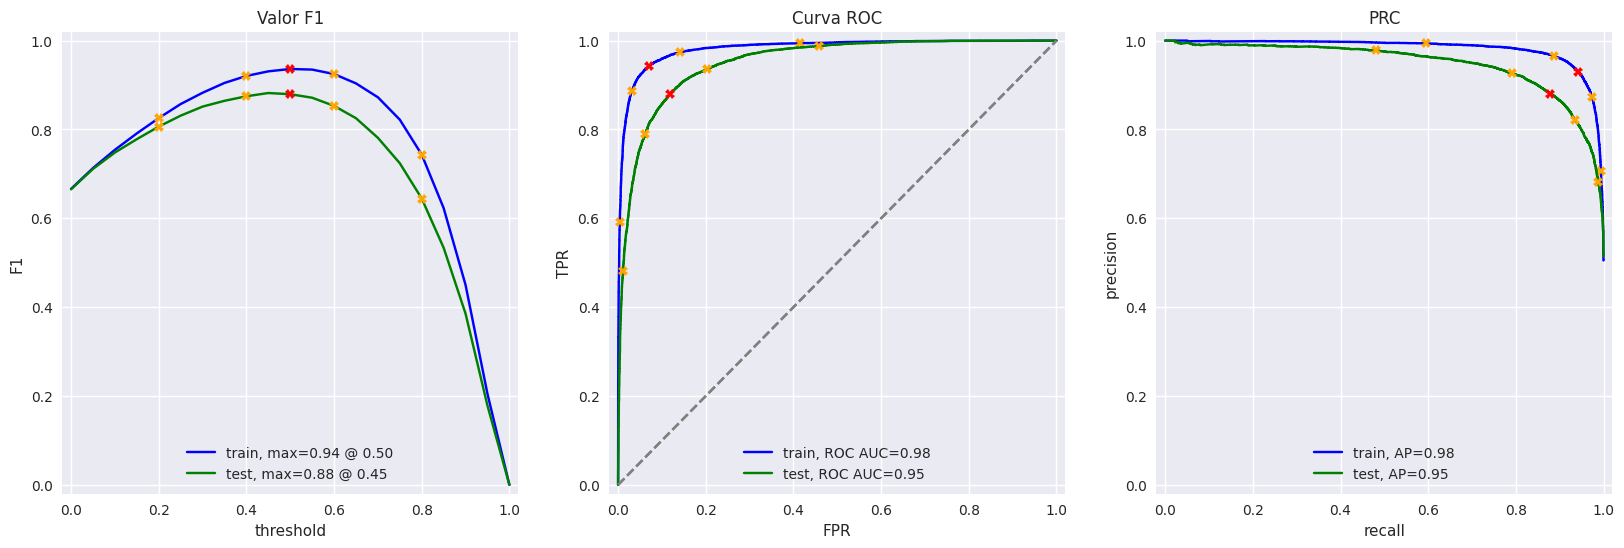

In [26]:
evaluate_model(model_1, features_train, target_train, features_test, test_target)

### Modelo 2 - spaCy, TF-IDF y LR

In [27]:
train_corpus = df_reviews_train["review_spacy"] # extraer reseñas lematizadas para el entrenamiento
stop_words = set(stopwords.words("english")) # definir las palabras vacías

count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words) # inicializar TfidVercorizer
tf_idf_2 = count_tf_idf_2.fit_transform(train_corpus) # ajustar y transformar el corpus de entrenamiento

features_train = tf_idf_2 # extraer características para el entrenamiento

target_train = train_target # extraer la columna objetivo

test_corpus = df_reviews_test["review_spacy"] # extraer reseñas lematizadas para la prueba

features_test = count_tf_idf_2.transform(test_corpus) # transformar el corpus de entrenamiento

model_2 = LogisticRegression() # inicializar el modelo de regresión logística y ajustarlo
model_2.fit(features_train, target_train)
pred_test = model_2.predict(features_test) # obtener predicciones para la parte de prueba de los datos

# transformar las predicciones en un DataFrame y guardarlo
submission = pd.DataFrame({"pos":pred_test})

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


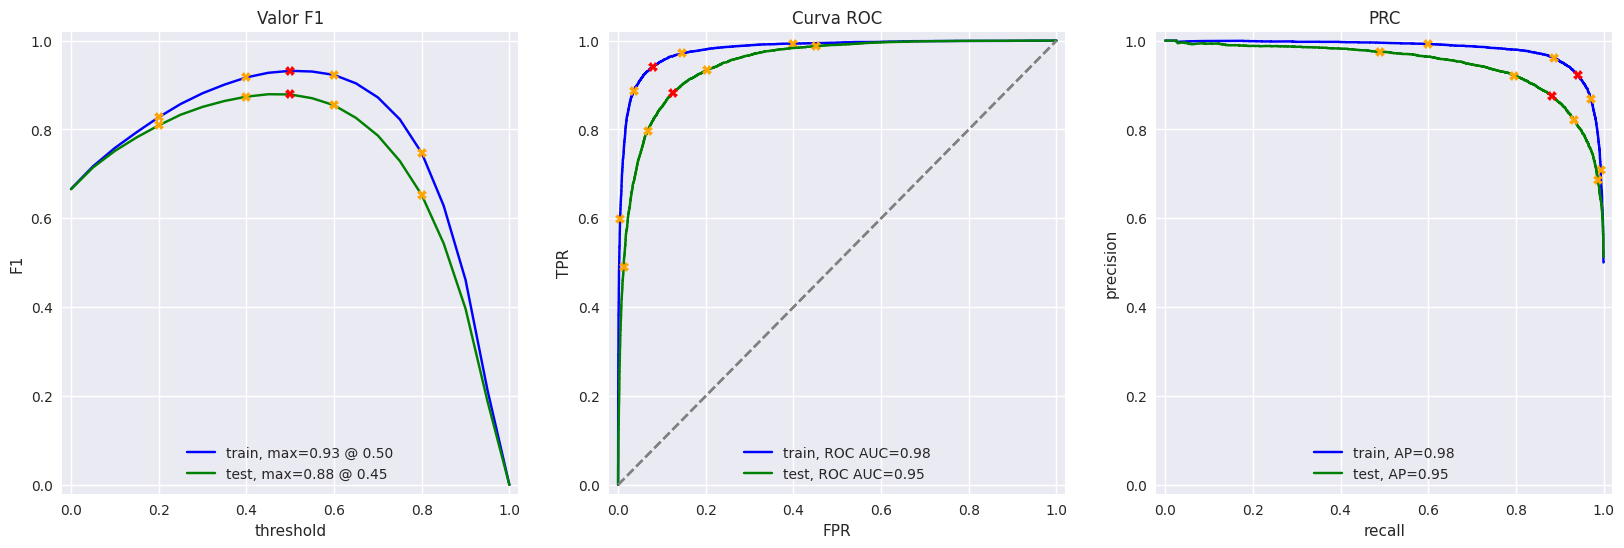

In [28]:
evaluate_model(model_2, features_train, target_train, features_test, test_target)

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

In [30]:
model_3 = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,)

# Entrenamiento
model_3.fit(features_train, target_train)

pred_test = model_3.predict(features_test) # obtener predicciones para la parte de prueba de los datos

# transformar las predicciones en un DataFrame y guardarlo
submission = pd.DataFrame({"pos":pred_test})

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


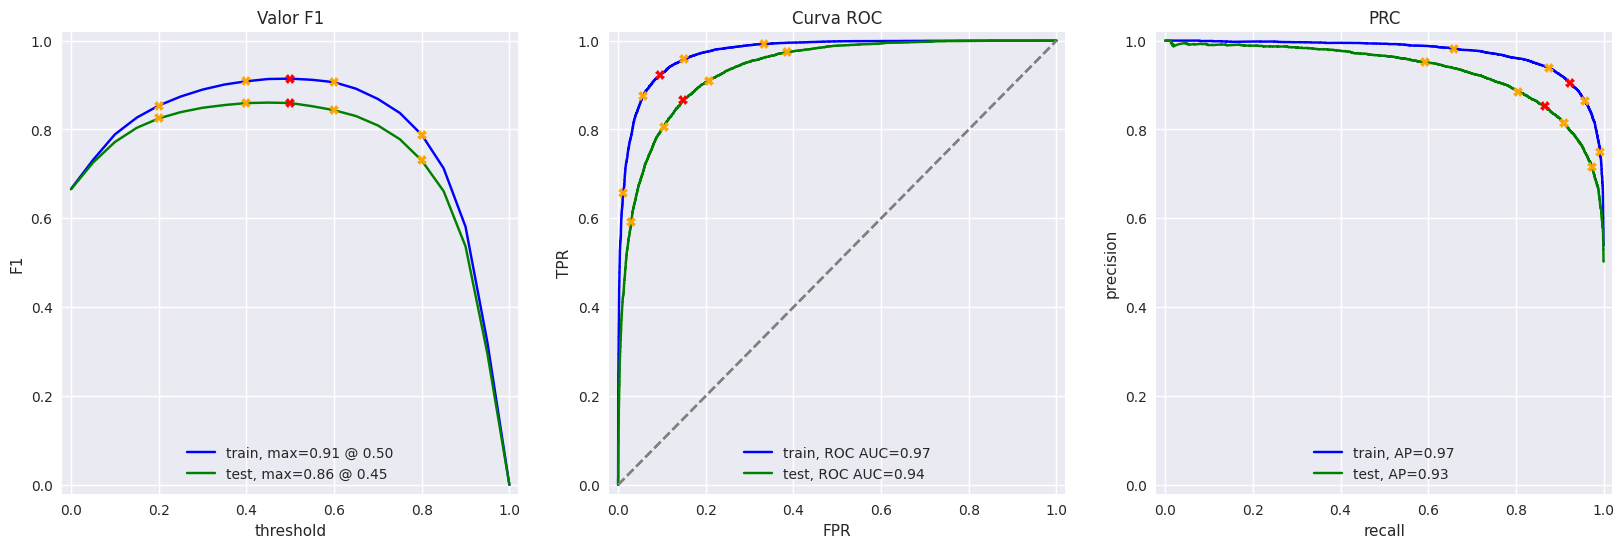

In [31]:
evaluate_model(model_3, features_train, target_train, features_test, test_target)

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Excelente! Entrenaste diferentes modelos y se obtuvieron métricas bastante buenas! Siempre procura buscar una forma amigable de explicar el resultado del performance en tu modelo, por ejemplo, las gráficas utilizadas aquí son muy buenas para explicar el comportamiento de los modelos
</div>

###  Modelo 9 - BERT

No puedo utilizar el modelo BERT, si tengo el argumento force_device en "cuda" no reconoce la GPU y si esta en "cpu" el kernel se crashea. :(

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Por la limitacíon de GPU es que se deja cómo opcional esta parte Sebastian, si lo estabas intentando ejecutar en la plataforma no te reconocerá el device cómo "cuda" ya que no hay recursos de GPU, y con el CPU este tipo de modelos suele tardar muchísimo por la arquitectura que estos tienen. Si quisieras investigar o probar un poco más este tipo de arquitecturas te recomiendo Google Colab que sólo con tu cuenta gmail te permite acceder a un entorno de Jupyter con acceso a GPU de manera gratuita
</div>

In [32]:
#import torch
#import transformers

In [33]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [34]:
#max_sample_size = 200

#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

#    ids_list = []
#    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

#    for input_text in df_reviews.iloc[:max_sample_size]['review']:
#        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
#        padded = np.array(ids + [0]*(max_length - len(ids)))
#        attention_mask = np.where(padded != 0, 1, 0)
#        ids_list.append(padded)
#        attention_mask_list.append(attention_mask)
    

#    if force_device is not None:
#        device = torch.device(force_device)
#    else:
#        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#    model.to(device)
#    if not disable_progress_bar:
#        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

#    embeddings = []

#    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

#        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * (i + 1)]).to(device)

#        with torch.no_grad():
#            model.eval()
#            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
#        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

#    return np.concatenate(embeddings)

In [35]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
#train_features_9 = BERT_text_to_embeddings(df_reviews_train["review_clean"], force_device='cuda')

In [36]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [37]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [38]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    ['I did not simply like it, not my kind of movie.', 0],
    ['Well, I was bored and felt asleep in the middle of the movie.', 0],
    ['I was really fascinated with the movie', 1],
    ['Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.', 0],
    ['I didn\'t expect the reboot to be so good! Writers really cared about the source material', 1],
    ['The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.', 1],
    ['What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!', 0],
    ['Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.', 1]
], columns=["review", "pos"])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews["review"] = my_reviews["review"].apply(clear_text)

my_reviews["review_spacy"] = my_reviews["review"].apply(spacy)

my_reviews["review_lntk"] = my_reviews["review"].apply(lntk)

my_reviews

,review,pos,review_spacy,review_lntk
0,I did not simply like it not my kind of movie,0,I do not simply like it not my kind of movie,i did not simply like it not my kind of movie
1,Well I was bored and felt asleep in the middle...,0,well I be bored and feel asleep in the middle ...,well i wa bored and felt asleep in the middle ...
2,I was really fascinated with the movie,1,I be really fascinated with the movie,i wa really fascinated with the movie
3,Even the actors looked really old and disinter...,0,even the actor look really old and disinterest...,even the actor looked really old and disintere...
4,I didn't expect the reboot to be so good Write...,1,I do not expect the reboot to be so good write...,i did n't expect the reboot to be so good writ...
5,The movie had its upsides and downsides but I ...,1,the movie have its upside and downside but I f...,the movie had it upside and downside but i fee...
6,What a rotten attempt at a comedy Not a single...,0,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move I really...,1,launch on netflix be a brave move I really app...,launching on netflix wa a brave move i really ...


### Modelo 1 - NLTK, TF-IDF y LR | Nuevo conjunto de reseñas

In [39]:
test_corpus = my_reviews["review_lntk"] # extraer reseñas lematizadas para la prueba

features_my_review = count_tf_idf_1.transform(test_corpus) # transformar el corpus de entrenamiento

In [40]:
pred_my_reviews = model_1.predict(features_my_review) # obtener predicciones para la parte de prueba de los datos

# transformar las predicciones en un DataFrame y guardarlo
my_reviews["pos_model_1"] = pd.DataFrame({"pos":pred_my_reviews})

In [41]:
my_reviews.loc[:, ["review", "pos_model_1"]]

,review,pos_model_1
0,I did not simply like it not my kind of movie,0
1,Well I was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,0
3,Even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good Write...,0
5,The movie had its upsides and downsides but I ...,1
6,What a rotten attempt at a comedy Not a single...,0
7,Launching on Netflix was a brave move I really...,1


<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Para esta última parte parece que hay una confusión, aquí no deberías evaluar, aquí solo deberías obtener la clasificación de las reseñas nuevas para ver cómo sería el funcionamiento de los modelos ya entrenados, aquí deberías mostrar si la reseña se clasifica cómo positiva o negativa
</div>

### Modelo 2 - spaCy, TF-IDF y LR | Nuevo conjunto de reseñas

In [42]:
test_corpus = my_reviews["review_spacy"] # extraer reseñas lematizadas para la prueba

features_my_review = count_tf_idf_2.transform(test_corpus) # transformar el corpus de entrenamiento

In [43]:
pred_my_reviews = model_2.predict(features_my_review) # obtener predicciones para la parte de prueba de los datos

# transformar las predicciones en un DataFrame y guardarlo
my_reviews["pos_model_2"] = pd.DataFrame({"pos":pred_my_reviews})

In [44]:
my_reviews.loc[:, ["review", "pos_model_2"]]

,review,pos_model_2
0,I did not simply like it not my kind of movie,0
1,Well I was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,0
3,Even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good Write...,0
5,The movie had its upsides and downsides but I ...,0
6,What a rotten attempt at a comedy Not a single...,0
7,Launching on Netflix was a brave move I really...,1


### Modelo 3 - spaCy, TF-IDF y LGBMClassifier | Nuevo conjunto de reseñas

In [45]:
test_corpus = my_reviews["review_spacy"] # extraer reseñas lematizadas para la prueba

features_my_review = count_tf_idf_2.transform(test_corpus) # transformar el corpus de entrenamiento

In [46]:
pred_my_reviews = model_3.predict(features_my_review) # obtener predicciones para la parte de prueba de los datos

# transformar las predicciones en un DataFrame y guardarlo
my_reviews["pos_model_3"] = pd.DataFrame({"pos":pred_my_reviews})

In [47]:
my_reviews.loc[:, ["review", "pos_model_3"]]

,review,pos_model_3
0,I did not simply like it not my kind of movie,1
1,Well I was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good Write...,1
5,The movie had its upsides and downsides but I ...,1
6,What a rotten attempt at a comedy Not a single...,0
7,Launching on Netflix was a brave move I really...,1


## Conclusiones

Para finalizar simplemente imprimimos el DataFrame con las etiquetas y las comparamos.

In [48]:
model_comparison = my_reviews.drop(["review_spacy", "review_lntk"], axis=1)

model_comparison

,review,pos,pos_model_1,pos_model_2,pos_model_3
0,I did not simply like it not my kind of movie,0,0,0,1
1,Well I was bored and felt asleep in the middle...,0,0,0,0
2,I was really fascinated with the movie,1,0,0,1
3,Even the actors looked really old and disinter...,0,0,0,0
4,I didn't expect the reboot to be so good Write...,1,0,0,1
5,The movie had its upsides and downsides but I ...,1,1,0,1
6,What a rotten attempt at a comedy Not a single...,0,0,0,0
7,Launching on Netflix was a brave move I really...,1,1,1,1


La columna "pos" son las etiquetas dadas a las reseñas de forma manual, y en base a estas podemos comparar las etiquetas dadas por los diferentes modelos.

Al comparar los modelos resulta muy evidente que el mejor modelo es el numero 3, ya que solo tuvo un falso positivo en el primer comentario.

Es ese falso positivo posiblemente se deba a como esta escrito el comentario, cuando dice "I did not simply like it" talvez al estar la negacion al lado izquierdo de la oracion no hace tantas relaciones con las palabras vecinas a diferencia de "like it" que esta en el medio. Posiblemente si la frase se ubiera escrito de forma mas comun, como por ejemplo: "i just didn't like it" el modelo ubiera clasificado la reseña como negativa.


<div class="alert alert-block alert-success">
<b>Comentario general (2da Iteracion)</b> <a class=“tocSkip”></a>

Hiciste un buen trabajo entrenando los diferentes modelos, obtuviste buenos scores en las métricas de evaluación con los mismos.
    
Cómo pudiste observar a lo largo de este proyecto para que los modelos puedan entender nuestro lenguaje o cómo los humanos se comunican primero hay que transformar estos textos a números utilizando vectorización para poder tener una representación de estos y que los modelos puedan realizar las asociaciones necesarias y así obtener predicciones.
    
Saludos!
</div>

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones